# MA3315: Introduction to Visual Computing
# Juan LONDONO
## Assignment 1

This assignment has two problems. 

Let us load the required libraries first. 

In [1]:
from __future__ import print_function
import cv2
import numpy as np
#import Image
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`
               

In [2]:
# Building the smoothing function using a gaussian filter

from scipy.ndimage import gaussian_filter

def gaussian_smoothing(image):
    """
    Inputs:
        image                The input image.
    
    Outputs:
        smoothed_image       The image smoothed through a Gaussian filter of Sigma = 3.
    """
    
    smoothed = gaussian_filter(image, sigma = 3)
    
    return smoothed

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

In [3]:
# Computing the gradient magnitude and direction with Sobel operators

def gradient(smoothed_image):
    """
    Inputs:
        smoothed_image       The image after a guassian smoothing.
    
    Outputs:
        g_magnitude          The magnitude of the gradient at each pixel.
        g_dir                The direction of the gradient at each pixel.
    """
    # We use the cv2.Sobel function from openCV
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

    # Calculating magnitude and direction thanks to the given formulas
    g_magnitude = np.sqrt( np.square(sobelx) + np.square(sobely) )
    g_dir = np.absolute( np.arctan2( sobely, sobelx ) )
    
    return g_magnitude, g_dir

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

In [4]:
def non_maximum_suppression(g_magnitude, g_dir):
    """
    Inputs:
        g_magnitude          The magnitude of the gradient at each pixel.
        g_dir                The direction of the gradient at each pixel.
    
    Outputs:
        g_max                Image magnitude with thined edges. 
    """
    pi = np.pi
    quant_g_dir = np.copy(g_dir)
    
    # Quantizing the gradient directions into the corresponding value based on their corresponding interval
    np.place(quant_g_dir, (quant_g_dir >= 0) & (quant_g_dir < pi/8), 0)
    np.place(quant_g_dir, (quant_g_dir >= pi/8) & (quant_g_dir < 3*pi/8), pi/4)
    np.place(quant_g_dir, (quant_g_dir >= 3*pi/8) & (quant_g_dir < 5*pi/8), pi/2)
    np.place(quant_g_dir, (quant_g_dir >= 5*pi/8) & (quant_g_dir < 7*pi/8), 3*pi/4)
    np.place(quant_g_dir, (quant_g_dir >= 7*pi/8), 0)
    
    # Padding the arrays
    pad_dir = np.pad(quant_g_dir, 1 , 'constant', constant_values=(0, 0))
    pad_mag = np.pad(g_magnitude, 1 , 'constant', constant_values=(0, 0))
    
    # Based on the 4 possible directions, we suppress the gradients at points 
    # that are not greater than the two neighbours
    for i in range(quant_g_dir.shape[0]):
        for j in range(quant_g_dir.shape[1]):
            if pad_dir[i,j] == 0:
                x = pad_mag[i,j]
                a = pad_mag[i,j-1]
                b = pad_mag[i,j+1]
                
                if x<=a or x<=b:
                    pad_mag[i,j] = 0
                    
            elif pad_dir[i,j] == pi/4:
                x = pad_mag[i,j]
                a = pad_mag[i-1,j+1]
                b = pad_mag[i+1,j-1]
                
                if x<=a or x<=b:
                    pad_mag[i,j] = 0
                    
            elif pad_dir[i,j] == pi/2:
                x = pad_mag[i,j]
                a = pad_mag[i-1,j]
                b = pad_mag[i+1,j]
                
                if x<=a or x<=b:
                    pad_mag[i,j] = 0
                    
            elif pad_dir[i,j] == 3*pi/4:
                x = pad_mag[i,j]
                a = pad_mag[i-1,j-1]
                b = pad_mag[i+1,j+1]
                
                if x<=a or x<=b:
                    pad_mag[i,j] = 0
                    
    g_max = pad_mag[1:-1,1:-1]
    
    return g_max               

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

In [5]:
def double_thresholding(g_max, thresh_lo, thresh_hi):
    """
    Inputs:
        thresh_lo          Low threshold.
        thresh_hi          High threshold.
        g_max              Image magnitude with thined edges. 
    
    Outputs:
        thresh_img         Thresholded image with only 3 possible values for points: [0, "weak", "strong"]. 
    """
    
    thresh_img = np.copy(g_max)
    
    # Setting the low and high threshold values
    low = thresh_lo*np.max(thresh_img)
    high = thresh_hi*np.max(thresh_img)
    
    # Seeting points below "low" to zero
    np.place(thresh_img, thresh_img <= low, 0)
    # Setting points greater than "high" to a "strong" value, here np.max(thresh_img)
    np.place(thresh_img, thresh_img >= high, np.max(thresh_img))
    # Setting points between "low" and "high" to a "weak" value, here np.max(thresh_img)/2
    np.place(thresh_img, (thresh_img > low) & (thresh_img < high), np.max(thresh_img)/2)
    
    return thresh_img

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

In [6]:
def connectivity(thresh_img):
    """
    Inputs:
        thresh_img         Thresholded image with only 3 possible values for points: [0, "weak", "strong"].
    
    Outputs:
         edge_img          Image with only "definite edges", i.e. strong points or weak points 
                           with at least one strong point in vicinity.
    """
    
    edge_img = np.copy(thresh_img)
    # Padding our image
    pad_edge = np.pad(edge_img, 1 , 'constant', constant_values=(0, 0))
    
    for i in range(1, (pad_edge.shape[0]-1)):
        for j in range(1, (pad_edge.shape[1]-1)):
            if pad_edge[i,j] == np.max(thresh_img)/2:
                # Setting weak points with one strong point in vicinity as a "definite edge"
                if np.max(pad_edge[i-1:i+1, j-1:j+1]) == np.max(thresh_img):
                    pad_edge[i,j] = 1
                # Setting weak points with no strong point in vicinity to 0
                else:
                    pad_edge[i,j] = 0
    
    edge_img = pad_edge[1:-1,1:-1]
    # Creating a binary image with values [0,1]
    edge_img[edge_img==np.max(thresh_img)] = 1
    
    return edge_img
            

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [7]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

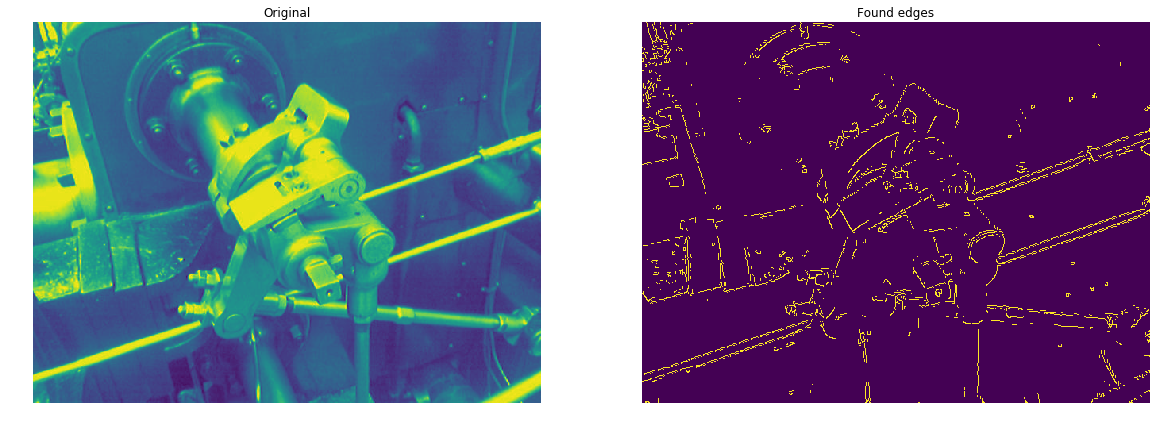

In [8]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = canny_edge_detector(img)

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

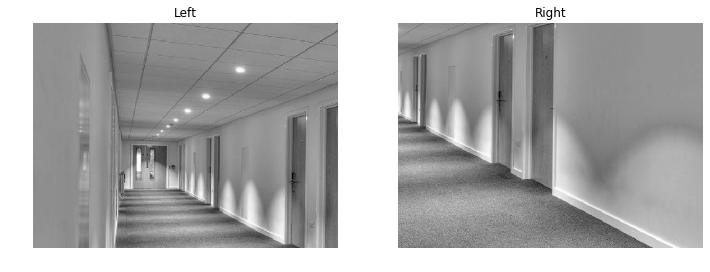

In [9]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [19]:
# Function to find corner points using Harris corner detector

def harris_corner_detector(img, blockSize = 2, ksize = 3, k = 0.04):
    """
    Inputs:
        img                The imput image.
        blockSize          Size of neighbourhood considered for corner detection.
        ksize              Aperture parameter of Sobel derivative used.
        k                  Harris detector free parameter in the equation.
    
    Outputs:
         detector          Array containing the values of all the detected (or not) corners at each pixel.
    """
    
    img      = np.float32(img)
    detector = cv2.cornerHarris(img, blockSize, ksize, k)
    
    # Threshold for an optimal value, to keep only important edges.
    detector[detector<0.01*detector.max()]=0
    
    return detector

In [15]:
# Function to find a random pair of corners from each image

def find_random_pair(corners_left, corners_right):
    """
    Inputs:
        corners_left       Image containing the values of all the detected corners in left image.
        corners_right      Image containing the values of all the detected corners in right image.
    
    Outputs:
         c_left            Indexes of the randomly selected corner of left image.
         c_right           Indexes of the randomly selected corner of right image.
    """
    
    left  = np.argwhere(corners_left!=0)
    right = np.argwhere(corners_right!=0)
    
    a = np.random.randint(0, left.shape[0])
    b = np.random.randint(0, right.shape[0])
    
    c_left  = tuple(left[a,:])
    c_right = tuple(right[b,:])
    
    return c_left, c_right

In [16]:
# Function to find the translation vector, so the we can superimpose points in the right image onto the left image

def find_translation_vector(c_left, c_right):
    """
    Inputs:
         c_left            Indexes of the randomly selected corner of left image.
         c_right           Indexes of the randomly selected corner of right image.
    
    Outputs:
         x_trans           X coordinate of the translation vector.
         y_trans           Y coordinate of the translation vector.
    """
    
    x_trans = c_left[0]-c_right[0]
    y_trans = c_left[1]-c_right[1]
    
    return x_trans, y_trans

In [17]:
# Function to calculate the similarity score between the patches of the two images 
# that correspond to the overlapping region.

def compute_error(left, right, c_left, c_right):
    """
    Inputs:
         left              Left image.
         right             Right image.
         c_left            Indexes of the randomly selected corner of left image.
         c_right           Indexes of the randomly selected corner of right image.
    
    Outputs:
         this_error        Error calculated when comparing the two patches of the overlapping region.
         patch_shape       Shape of the overlapping region.
    """
    # Creating right patch
    line = c_right[0] + (left.shape[0] - (c_left[0] + 1))
    col  = c_right[1] + (left.shape[1] - (c_left[1] + 1))
    right_patch  = right[:line+1, :col+1]

    # Creating left patch
    left_patch = left[c_left[0]-c_right[0]:, c_left[1]-c_right[1]:]
    
    # Only patches with similar shapes can be compared
    if right_patch.shape == left_patch.shape:

        # Calculating error using MSE
        this_error = right_patch - left_patch
        this_error = np.absolute(this_error)
        this_error = np.sum(this_error) / (right_patch.shape[0]*right_patch.shape[1])
        
        # Calculating patch shape
        patch_shape = right_patch.shape
        
        return this_error, patch_shape
    
    # Patches with different shapes give a maximum error and no patch shape
    else :
        this_error = 255*left.shape[0]*left.shape[1]
        patch_shape = (0,0)
        return this_error, patch_shape

In [18]:
def stitch_images(left, right, max_tries=1000):
    # Find corner points
    corners_left  = harris_corner_detector(left)
    corners_right = harris_corner_detector(right)
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error and patch shape. 
        this_error, patch_shape = compute_error(left, right, c_left, c_right)
        
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
    
    # Computing the shape of the expected stitched image based on the patched shape
    stiched_image_shape = (2*left.shape[0]-patch_shape[0], 2*left.shape[1]-patch_shape[1])
            
    stitched_image = np.zeros(stiched_image_shape)
    stitched_image[:left.shape[0],:left.shape[1]] = left
    stitched_image[-right.shape[0]:,-right.shape[1]:] = right
    
    return stitched_image

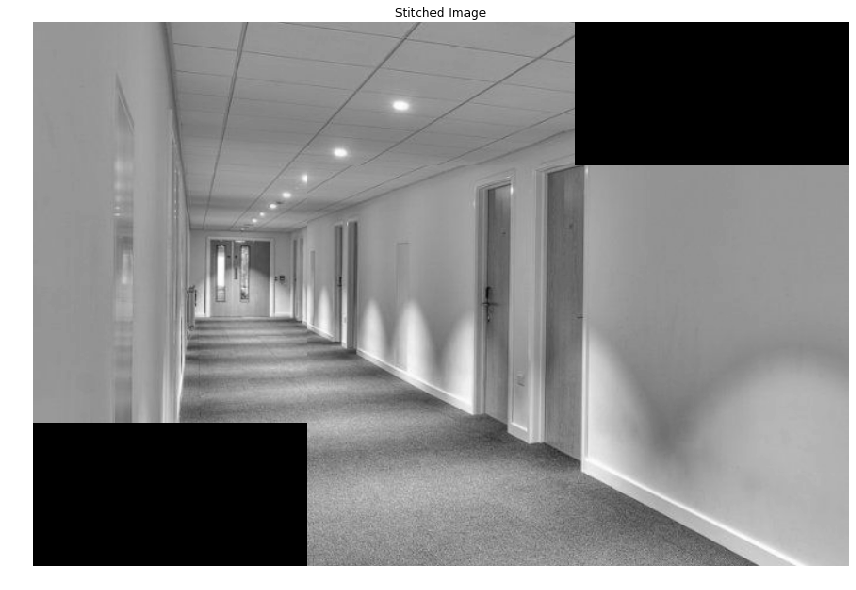

In [229]:
stiched_image = stitch_images(left_img, right_img, max_tries=10000)

plt.figure(figsize=(20,10))

plt.imshow(stiched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')

plt.show()

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

> To account for other affine transformations or viewpoint differences between the two images, such as rotations or scaling, we could for instance use the RANSAC algorithm for homography.

> This way, instead of taking one pair of random points in each image, we now take two. We then compute the homography, and use this homography in the same way that we used our translation vector above. We would then proceed the same way than previously.